## 1. Load Data

In [76]:
import pandas as pd
import numpy as np

df_2015 = pd.read_csv('2015_fuel_data.csv')
df_2016 = pd.read_csv('2016_fuel_data.csv')
df_2017 = pd.read_csv('2017_fuel_data.csv')
df_2018 = pd.read_csv('2018_fuel_data.csv')

# Delete the Null in NP array 
df_2015 = df_2015[pd.isnull(df_2015['Model Year']) == False]
df_2016 = df_2016[pd.isnull(df_2016['Model Year']) == False]
df_2017 = df_2017[pd.isnull(df_2017['Model Year']) == False]
df_2018 = df_2018[pd.isnull(df_2018['Model Year']) == False]

# predicted value
y_2015 = df_2015['Comb Unrd Adj FE - Conventional Fuel']
y_2016 = df_2016['Comb Unrd Adj FE - Conventional Fuel']
y_2017 = df_2017['Comb Unrd Adj FE - Conventional Fuel']
y_2018 = df_2018['Comb Unrd Adj FE - Conventional Fuel']

# features names
features = df_2015.columns.get_values() 

311

## 2. Preprocess the data

### Remove related features

In [230]:
# Array with strings to remove
remove_array = ["EPA", "Rating", "FE", "Cost", "Range", "CO2", "Guzzler", "MPG", "Smog", 'Unnamed', 'costs']

# Deciding Which Features to Keep
keep_array = features
remove_indices = []
for i in features: 
    for j in remove_array: 
        if i.find(j) != -1: 
            index = np.where(features==i)
            remove_indices.append(index)
            
keep_array = np.delete(keep_array, remove_indices)         

### Extract remaining features and seperate by types

In [307]:
raw_X_2015 = df_2015[keep_array]
raw_X_2016 = df_2016[keep_array]
raw_X_2017 = df_2017[keep_array]
raw_X_2018 = df_2018[keep_array]

# numerical features
float_data = list(raw_X_2015.select_dtypes(include=['float64']).columns)
# categorical features
object_data = list(raw_X_2015.select_dtypes(include=['object']).columns)


(3701, 96)

### Merge training data

In [316]:
X_raw_all = raw_X_2015.append(raw_X_2016).append(raw_X_2017).append(raw_X_2018) # add 2018 as well
Y = y_2015.append(y_2016).append(y_2017)
X_raw = raw_X_2015.append(raw_X_2016).append(raw_X_2017)

### Encode categorical data

In [348]:
def transform_categorical(data_frame, columns): 
    df_new = data_frame[columns]
    return( pd.get_dummies(df_new) )
        
categorical_raw_all = transform_categorical(X_raw_all, object_data)
categorical_raw_train = categorical_raw_all[:3701]
categorical_raw_2018 = categorical_raw_all[3701:]


## 3. Feature selection and scale the data

In [349]:
train_feature = []
totalValidRow = [True] * len(Y)
print('Selected Features:')
for feature in float_data:
    validIndex = pd.notnull(X_raw[feature])
    # select feature with specific percent of valid rows 
    if len(validIndex[validIndex == True]) < 0.4*len(validIndex) or feature in [ '# Batteries']: 
        continue
    totalValidRow = totalValidRow & validIndex
    train_feature.append(feature)
    print(feature)
    #print(np.corrcoef(raw_X_2015[feature][validIndex],y_2015[validIndex]))
print('Number of selected numerical features:', len(train_feature))
print('Total rows to be chosen:', len(totalValidRow[totalValidRow == True]))
# X_raw[train_feature]['Model Year']
index2015to2017 = X_raw_all[train_feature]['Model Year'][X_raw_all[train_feature]['Model Year'] != 2018]
index2018 = X_raw_all[train_feature]['Model Year'][X_raw_all[train_feature]['Model Year'] == 2018]
print(len(index2015to2017), len(index2018))

Selected Features:
Model Year
Index (Model Type Index)
Eng Displ
# Cyl
# Gears
Max Ethanol % - Gasoline
Intake Valves Per Cyl
Exhaust Valves Per Cyl
Carline Class
Number of selected numerical features: 9
Total rows to be chosen: 3621
3701 1220


### Exclude empty row, scale numerical data, merge the data and split train test data

**Training on 2015-2017 data, test on 2018 data.**

In [359]:
# training data
X = X_raw[train_feature][totalValidRow]

categorical_X = categorical_raw_train[totalValidRow] # catergorical data
categorical_data = categorical_X.as_matrix()

# scale the numerical data
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X) # numerical data

# combine the training data
x_combine_train = np.concatenate((X_scaled, categorical_data), axis=1)
y_train = Y[totalValidRow]
print('train data feature shape', x_combine_train.shape)  
print('train predict data shape', y_train.shape)

# extract valid row from test data
totalValidRowTest = [True] * len(y_2018)
for feature in train_feature:
    validIndex = pd.notnull(raw_X_2018[feature])
    totalValidRowTest = totalValidRowTest & validIndex

X_test = raw_X_2018[train_feature][totalValidRowTest]
X_test_scaled = scaler.transform(X_test)
# print('X_test_scaled' ,X_test_scaled.shape)
categorical_X_test = categorical_raw_2018[totalValidRowTest]
categorical_data_test = categorical_X_test.as_matrix()

# combine the test data
x_combine_test = np.concatenate((X_test_scaled, categorical_data_test), axis=1)
y_test = y_2018[totalValidRowTest]
print('test data feature shape', x_combine_test.shape)  
print('test predict data shape', y_test.shape)

train data feature shape (3621, 3316)
train predict data shape (3621,)
test data feature shape (1194, 3316)
test predict data shape (1194,)


### Task 1 Linear Models
Measure performance of a linear model using the provided features with appropriate
preprocessing.

**With 9 numerical features and 3307 binary features, Ridge regression has the best test score of 0.9568 with the 2018 data.**

In [360]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

ridge = Ridge().fit(x_combine_train, y_train)
start = datetime.now()
print('Ridge Regression Validation Score',np.mean(cross_val_score(Ridge(), x_combine_train, y_train, cv=10)))
print('Ridge Regression Test Score', ridge.score(x_combine_test, y_test))
print(datetime.now()-start)

Ridge Regression Validation Score 0.9423918314776418
Test Score 0.9568685740854399
0:00:18.389154


### Task 2 Feature Engineering
Build non-linear features or derived features from the provided column. Try to improve the
performance of a linear model with these.

**We chose to build interaction features between the 9 numerical features and the 3307 binary features. Ridge Regression has excellent test score at 0.94965 with the 2018 data.**

In [ ]:
# 9 numerical features interact with 3000 binary features
#ASSUMES 9 categorical features! 

for i in range(0, 9): 
    if i == 0: 
        x_i_train = np.hstack([x_combine_train, x_combine_train[:, i:i+1], x_combine_train[:, 9:]])
        x_i_test = np.hstack([x_combine_test, x_combine_test[:, i:i+1], x_combine_test[:, 9:]])
    elif i > 0: 
        x_temp_train = np.hstack([x_combine_train, x_combine_train[:, i:i+1], x_combine_train[:, 9:]])
        x_temp_test = np.hstack([x_combine_test, x_combine_test[:, i:i+1], x_combine_test[:, 9:]])
        x_i_train = np.concatenate((x_i_train, x_temp_train), axis=1) 
        x_i_test = np.concatenate((x_i_test, x_temp_test), axis=1) 

# print(x_i_train.shape, x_i_test.shape) 

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from datetime import datetime

ridge_i = Ridge().fit(x_i_train, y_train)
start = datetime.now()
print('Ridge Regression Validation Score',np.mean(cross_val_score(Ridge(), x_i_train, y_train, cv=10)))
print('Ridge Regression Test Score', ridge_i.score(x_i_test, y_test))
print(datetime.now()-start)

### Task 3 Any models
Use any regression model we discussed (trees, forests, gradient boosting, SVM) to improve
your result. You can (and probably should) change your preprocessing and feature engineering
to be suitable for the model. You are not required to try all of these models.

In [362]:
from xgboost import XGBRegressor
xgb = XGBRegressor()
xgb.fit(x_combine_train, y_train)
print('XGBoost Validation Score:', np.mean(cross_val_score(XGBRegressor(), x_combine_train, y_train)))
print('XGBoost Test Score:', xgb.score(x_combine_test, y_test))

XGBoost Validation Score: 0.933932545004671
XGBoost Test Score: 0.9326001079507726


### Task 4 Feature Selections
Identify features that are important for your best model. Which features are most influential,
and which features could be removed without decrease in performance? Does removing
irrelevant features make your model better?

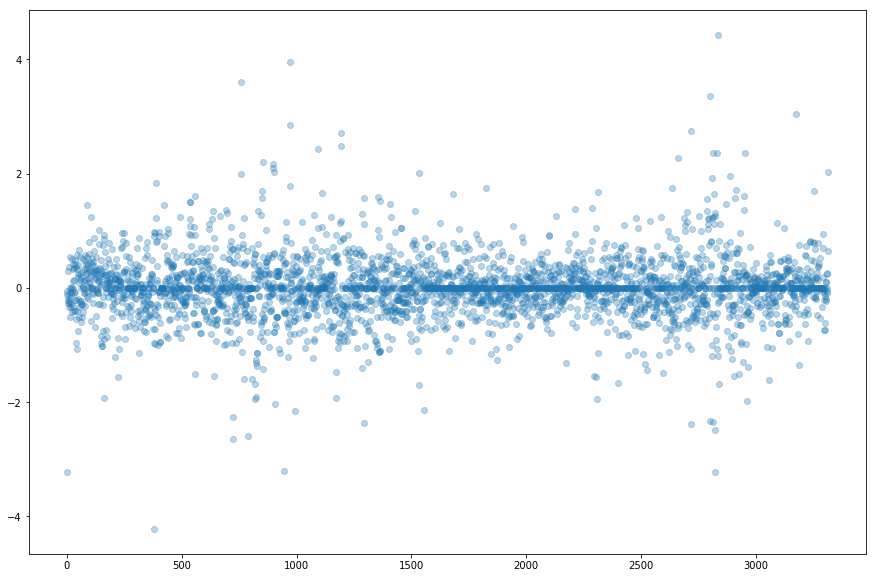

In [385]:
import matplotlib.pyplot as plt
# plot coefficients from ridge regression
plt.figure(figsize = (15, 10))
plt.plot(ridge.coef_, 'o', alpha = 0.3)
plt.show()

### Find influential features

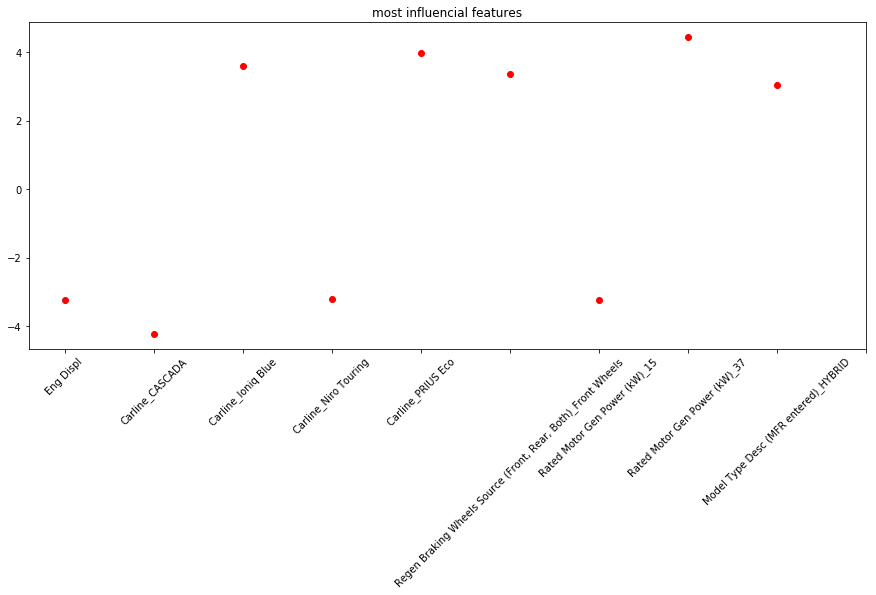

In [437]:
# combine feature names
feature_names = train_feature + list(categorical_raw_all)
# extract the most influential features
best_features_index =  abs(ridge.coef_) > 3
plt.figure(figsize = (15, 6))
plt.plot(ridge.coef_[best_features_index], 'ro')
selected_features_names = [name for name, flag in zip(feature_names, best_features_index) if flag == True]
plt.xticks(range(10),selected_features_names, rotation=45)
plt.title('most influencial features')
plt.show()

### Find features that have low impact

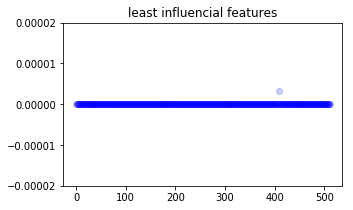

In [457]:
bad_features_index =  abs(ridge.coef_) < 0.00005
plt.figure(figsize = (5, 3))
plt.plot(ridge.coef_[bad_features_index], 'bo', alpha = 0.2)
plt.ylim(-0.00002, 0.00002)
#selected_features_names = [name for name, flag in zip(feature_names, bad_features_index) if flag == True]
#plt.xticks(range(len(selected_features_names)),selected_features_names, rotation=45)
plt.title('least influencial features')
plt.show()

**There are 512 features that have coefficients that are less than 0.00005.**

In [459]:
print('Least influencial features names:', len(selected_features_names))
for name in selected_features_names:
    print(name)

Least influencial features names: 512
Mfr Name_Koenigsegg
Division_Koenigsegg Automotive AG
Carline_328d
Carline_328d xDrive
Carline_328d xDrive Sports Wagon
Carline_535d
Carline_535d xDrive
Carline_540d xDrive
Carline_640i xDrive Gran Turismo
Carline_740Ld xDrive
Carline_812 Superfast
Carline_911 Turbo S Exclusive
Carline_A5 Sportback quattro
Carline_ACCORD 2.0T SPORT/TOURING
Carline_AMG C 43 4MATIC (convertible)
Carline_AMG E 63 S 4MATIC (Station Wagon
Carline_AMG GT (coupe)
Carline_AMG GT (roadster)
Carline_AMG GT C (coupe)
Carline_AMG GT C (roadster)
Carline_AMG GT R (coupe)
Carline_AMG GT S (coupe)
Carline_Agera RS
Carline_Atlas
Carline_Atlas 4Motion
Carline_Aventador S Coupe
Carline_Aventador S Roadster
Carline_BRZ tS
Carline_C 300 4MATIC (convertible)
Carline_C-HR
Carline_CAMRY LE/SE
Carline_CAMRY XLE/XSE
Carline_CAMRY XSE
Carline_COOPER CLUBMAN
Carline_COOPER CLUBMAN ALL4
Carline_COOPER CONVERTIBLE
Carline_COOPER COUNTRYMAN
Carline_COOPER COUNTRYMAN ALL4
Carline_COOPER HARDTOP 

### Remove the features that are not influential and retrain the model

In [485]:
good_train_data = x_combine_train[:,~bad_features_index]
good_test_data = x_combine_test[:,~bad_features_index]
ridge = Ridge().fit(good_train_data, y_train)
start = datetime.now()
print('Ridge regression validation score after removing trivial data',np.mean(cross_val_score(Ridge(), good_train_data, y_train, cv=10)))
print('Ridge regression test score after removing trivial data', ridge.score(good_test_data, y_test))
print(datetime.now()-start)

Ridge regression validation score after removing trival data 0.9423982862037972
Ridge regression test score after removing trival data 0.956868573333989
0:00:12.866290


- The orginial ridge regression model has validation score of 0.9423918314776418 and test score of 0.9568685740854399, which is about the same as the results above.
- **So we can see that remove the trivial data doesn't necessarily improve the result.**